<a href="https://colab.research.google.com/github/bhavika67/movie_recommendation_system/blob/main/graph_based_movie_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
import random

**Data Loading and Preprocessing**

In [4]:
movies = pd.read_csv("/content/movie.csv")
ratings = pd.read_csv("/content/rating.csv")
links = pd.read_csv("/content/link.csv")
tags = pd.read_csv("/content/rating.csv")
movies.shape, ratings.shape, links.shape, tags.shape

((27278, 3), (6401531, 4), (27278, 3), (6615475, 4))

In [6]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [8]:
links.head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [9]:
tags.head(5)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6401531 entries, 0 to 6401530
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 195.4+ MB


In [11]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [12]:
ratings = ratings.loc[:,["userId","movieId","rating"]]
movies = movies.loc[:,["movieId","title"]]

Data Size and Sampling

In [13]:
movie_and_rating = pd.merge(movies,ratings)
movie_and_rating.shape

(6401531, 4)

In [14]:
movie_and_rating.head(5)

,movieId,title,userId,rating
0,1,Toy Story (1995),3,4.0
1,1,Toy Story (1995),6,5.0
2,1,Toy Story (1995),8,4.0
3,1,Toy Story (1995),10,4.0
4,1,Toy Story (1995),11,4.5


Data Size and Sampling


In [15]:
movie_and_rating_sampled = movie_and_rating.sample(n=10000, random_state=1)
movie_and_rating_sampled.shape

(10000, 4)

In [16]:
movie_and_rating_sampled.head(10)

,movieId,title,userId,rating
4231163,3498,Midnight Express (1978),19931,3.5
3597793,2657,"Rocky Horror Picture Show, The (1975)",34447,4.0
2378926,1343,Cape Fear (1991),2062,3.5
4892252,4993,"Lord of the Rings: The Fellowship of the Ring,...",22517,3.0
5041290,5481,Austin Powers in Goldmember (2002),367,3.5
950425,440,Dave (1993),15394,5.0
4148746,3358,Defending Your Life (1991),16157,4.5
3168332,2141,"American Tail, An (1986)",40981,3.5
2631358,1589,Cop Land (1997),33639,3.0
5113150,5833,Dog Soldiers (2002),19722,3.5


In [17]:
pivot_table = movie_and_rating_sampled.pivot_table(index = ["userId"],columns = ["title"],values = "rating")
pivot_table.shape

(7471, 3332)

In [18]:
pivot_table.head(10)

title,'Til There Was You (1997),"'burbs, The (1989)",(500) Days of Summer (2009),1-900 (06) (1994),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),102 Dalmatians (2000),11:14 (2003),12 (2007),...,Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zoom (2006),"Zorro, the Gay Blade (1981)",eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Building the User-Item Interaction Matrix**


In [19]:
pivot_table = pivot_table.fillna(0)

In [20]:
pivot_table.head(10)

title,'Til There Was You (1997),"'burbs, The (1989)",(500) Days of Summer (2009),1-900 (06) (1994),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),102 Dalmatians (2000),11:14 (2003),12 (2007),...,Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zoom (2006),"Zorro, the Gay Blade (1981)",eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
random_movie = np.random.choice(pivot_table.columns)
movie_ratings = pivot_table[random_movie]
similarity_with_other_movies = pivot_table.corrwith(movie_ratings)
similarity_with_other_movies = similarity_with_other_movies.sort_values(ascending=False)
similarity_with_other_movies.head(5)

,0
title,
Monument Ave. (1998),1.000000
Made (2001),1.000000
Bachelor Party (1984),0.502858
"Three Burials of Melquiades Estrada, The (2006)",-0.000134
In the Loop (2009),-0.000134


In [22]:
similarity_with_other_movies.describe()

,0
count,3332.000000
mean,0.000549
std,0.026002
min,-0.000838
25%,-0.000231
50%,-0.000154
75%,-0.000134
max,1.000000


**Collaborative Filtering: Cosine Similarity**

In [23]:
# Normalize the data for better similarity computation
normalized_data = normalize(pivot_table, axis=0)
cosine_sim = cosine_similarity(normalized_data.T)

# Create a DataFrame for the similarity matrix
cosine_sim_df = pd.DataFrame(cosine_sim, index=pivot_table.columns, columns=pivot_table.columns)

In [24]:
cosine_sim_df.head(10)

title,'Til There Was You (1997),"'burbs, The (1989)",(500) Days of Summer (2009),1-900 (06) (1994),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),102 Dalmatians (2000),11:14 (2003),12 (2007),...,Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zoom (2006),"Zorro, the Gay Blade (1981)",eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"'burbs, The (1989)",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(500) Days of Summer (2009),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-900 (06) (1994),0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians (1996),0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians (One Hundred and One Dalmatians) (1961),0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102 Dalmatians (2000),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11:14 (2003),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Creating the User-Item Graph and Applying PageRank**

In [25]:
# Create a bipartite graph of user-item interactions (users and movies as nodes)
G = nx.Graph()

G.add_nodes_from(pivot_table.index, bipartite=0)
G.add_nodes_from(pivot_table.columns, bipartite=1)

print(len(pivot_table.index))
print(len(pivot_table.columns))

7471
3332


In [26]:
# Adding edges
for user in pivot_table.index:
    for movie in pivot_table.columns:
        rating = pivot_table.loc[user, movie]
        if rating > 0:  # Add edges only if the user has rated the movie
            G.add_edge(user, movie, weight=rating)

In [27]:
list(G.edges)[:20]

[(11, 'Crash (2004)'),
 (14, 'Greatest Game Ever Played, The (2005)'),
 (14, 'Lake House, The (2006)'),
 (18, 'Misfits, The (1961)'),
 (44, 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)'),
 (48, 'Shallow Grave (1994)'),
 (51, 'Rain Man (1988)'),
 (69, 'Fargo (1996)'),
 (69, 'Tombstone (1993)'),
 (70, 'Casino (1995)'),
 (71, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (72, 'Truman Show, The (1998)'),
 (73, 'Star Trek: Generations (1994)'),
 (82, 'In the Loop (2009)'),
 (83, 'Desperado (1995)'),
 (91, 'One Day in September (1999)'),
 (91, 'Shot in the Dark, A (1964)'),
 (102, 'Matrix, The (1999)'),
 (104, 'Body Heat (1981)'),
 (116, 'Mr. 3000 (2004)')]

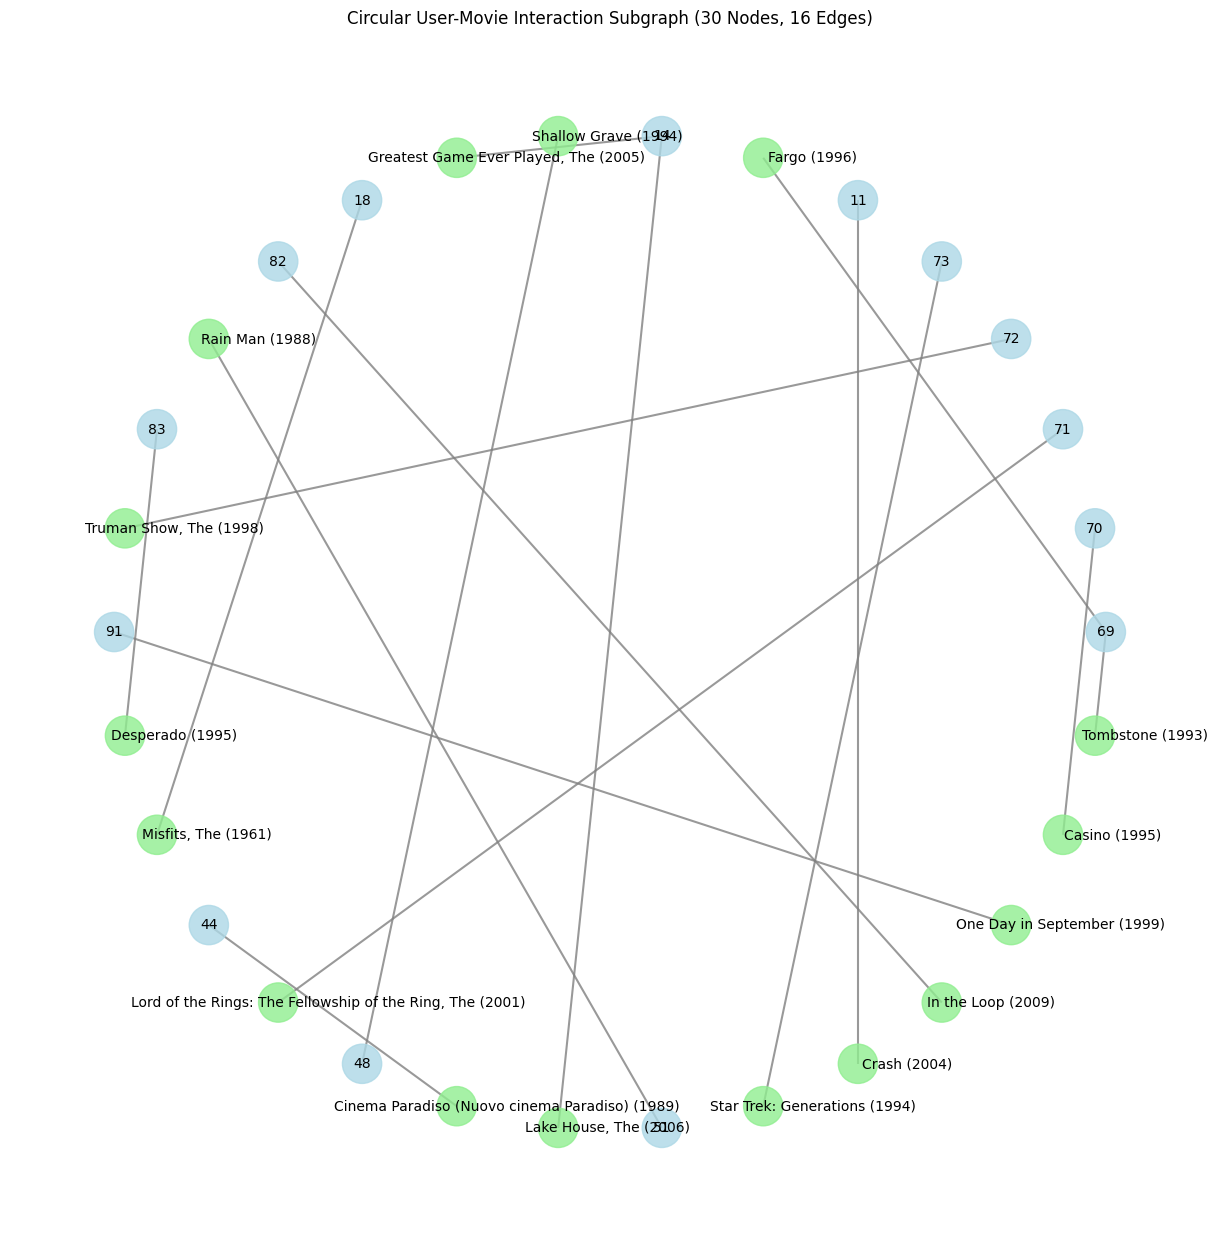

In [30]:
edges = list(G.edges)

if not edges:
    print("The graph has no edges.")
else:
    selected_edges = []
    selected_nodes = set()

    for edge in edges:
        if len(selected_nodes) < 30:
            u, v = edge
            if u not in selected_nodes or v not in selected_nodes:
                selected_edges.append(edge)
                selected_nodes.update([u, v])

    #Create a subgraph from the selected edges
    subgraph = G.edge_subgraph(selected_edges).copy()

    pos = nx.circular_layout(subgraph)

    # Plot the subgraph
    plt.figure(figsize=(12, 12))
    node_colors = ['lightblue' if isinstance(node, int) else 'lightgreen' for node in subgraph.nodes] # Removed extra space here

    # Draw the graph without labels
    nx.draw(subgraph, pos, with_labels=False, node_size=800, font_size=10,
            node_color=node_colors, edge_color='gray', width=1.5, alpha=0.8)

   # Users (first element in the tuple) will have user ID as label
    user_labels = {node: str(node) for node in subgraph.nodes if isinstance(node, int)}

    # Movies (second element in the tuple) will have movie title as label
    movie_labels = {node: node for node in subgraph.nodes if isinstance(node, str)}

    movie_pos = {node: (pos[node][0] + 0.1, pos[node][1]) for node in movie_labels}
    nx.draw_networkx_labels(subgraph, movie_pos, labels=movie_labels, font_size=10, font_color='black')
    nx.draw_networkx_labels(subgraph, pos, labels=user_labels, font_size=10, font_color='black')

    plt.title(f"Circular User-Movie Interaction Subgraph ({len(subgraph.nodes)} Nodes, {len(subgraph.edges)} Edges)")
    plt.show()

**Visualization of User-Item Interaction Subgraph**

Ranking Movies Using PageRank

In [31]:
# Apply PageRank to the graph to rank movies (we focus on movie nodes)
pagerank_scores = nx.pagerank(G, alpha=0.85)

# Extract the PageRank scores for movies
movie_pagerank_scores = {movie: score for movie, score in pagerank_scores.items() if movie in pivot_table.columns}

# Sort the movies based on their PageRank scores
sorted_movies_by_pagerank = sorted(movie_pagerank_scores.items(), key=lambda x: x[1], reverse=True)

# Display the top 10 movies based on PageRank
sorted_movies_by_pagerank[:10]

[('Shawshank Redemption, The (1994)', 0.0017030225330033186),
 ('Braveheart (1995)', 0.0014089890634033362),
 ('Forrest Gump (1994)', 0.0013917069094711112),
 ('Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
  0.0013292836947749606),
 ('Jurassic Park (1993)', 0.0012219175402398202),
 ("Schindler's List (1993)", 0.0011464736891601047),
 ('Apollo 13 (1995)', 0.0011351668826308182),
 ('Silence of the Lambs, The (1991)', 0.001124243319461183),
 ('American Beauty (1999)', 0.00111487933935747),
 ('Toy Story (1995)', 0.0011042418082750029)]

**Combining Collaborative Filtering and PageRank for Recommendations**

In [32]:
print(pivot_table.index)

Index([   11,    14,    18,    44,    48,    51,    69,    70,    71,    72,
       ...
       43879, 43883, 43892, 43917, 43921, 43925, 43937, 43940, 43942, 43945],
      dtype='int64', name='userId', length=7471)


In [34]:
def get_recommendations(user_id, G, pivot_table, top_n=10, c_f_importance=0.5):
    """
    Get movie recommendations for a user based on a hybrid approach combining collaborative filtering
    (cosine similarity) and PageRank.

    Parameters:
    - user_id: The user for whom we are generating recommendations.
    - G: The bipartite graph (user-item interaction graph).
    - pivot_table: The user-item matrix containing ratings.
    - top_n: Number of recommendations to return.

    Returns:
    - top_n_recommendations: List of top 'n' movie recommendations.
    """

    train_data = pivot_table.copy()
    train_data.fillna(0, inplace=True)

    user_ratings = train_data.loc[user_id].values
    rated_movies = train_data.columns[train_data.loc[user_id] > 0]
      # Generate cosine similarity between the user and all other users based on ratings
    other_users_ratings = train_data.drop(user_id, axis=0).values
    similarities = cosine_similarity([user_ratings], other_users_ratings)

    # Get the most similar users
    similar_users_idx = similarities.argsort()[0, ::-1]

    recommended_movies = set()
    for user_idx in similar_users_idx:
        similar_user_id = train_data.index[user_idx]
        similar_user_ratings = train_data.loc[similar_user_id]

        new_movies = similar_user_ratings[similar_user_ratings > 0].index.difference(rated_movies)
        recommended_movies.update(new_movies)

        if len(recommended_movies) >= top_n:
            break

    # Apply PageRank on the movie nodes (bipartite graph)
    movie_nodes = [node for node in G.nodes if isinstance(node, str)]
    subgraph = G.subgraph(movie_nodes)
    pagerank_scores = nx.pagerank(subgraph)
    #The line below was indented too much, removed the extra space
    movie_scores = {}
    for movie in recommended_movies:
        cf_score = similarities[0, similarities.argsort()[0, ::-1]][0]
        pr_score = pagerank_scores.get(movie, 0)

        combined_score = (c_f_importance) * cf_score + (1 - c_f_importance) * pr_score
        movie_scores[movie] = combined_score

    top_movies = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_n_recommendations = [movie for movie, score in top_movies]

    return top_n_recommendations

In [35]:
# Usage
evaluation_results = []
for i in range(0,100):
    user_id = pivot_table.index[i]
    recommended_movies = get_recommendations(user_id, G, pivot_table, top_n=20)
    evaluation_results.append({
            'User ID': user_id,
            'Recommendation' : recommended_movies
        })

# TODO: REMOVE THIS SECTION

evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df.head(10)

,User ID,Recommendation
0,11,"[I Know What You Did Last Summer (1997), Tamin..."
1,14,"[Billy Madison (1995), Babe (1995), I Know Wha..."
2,18,"[Billy Madison (1995), I Know What You Did Las..."
3,44,"[I Know What You Did Last Summer (1997), Corri..."
4,48,"[Billy Madison (1995), I Know What You Did Las..."
5,51,"[I Know What You Did Last Summer (1997), Fletc..."
6,69,[Bicycle Thieves (a.k.a. The Bicycle Thief) (a...
7,70,"[I Know What You Did Last Summer (1997), Fish ..."
8,71,"[North by Northwest (1959), Aladdin and the Ki..."
9,72,"[Girl 6 (1996), Boogie Nights (1997), Dune (20..."


**Visualizations**

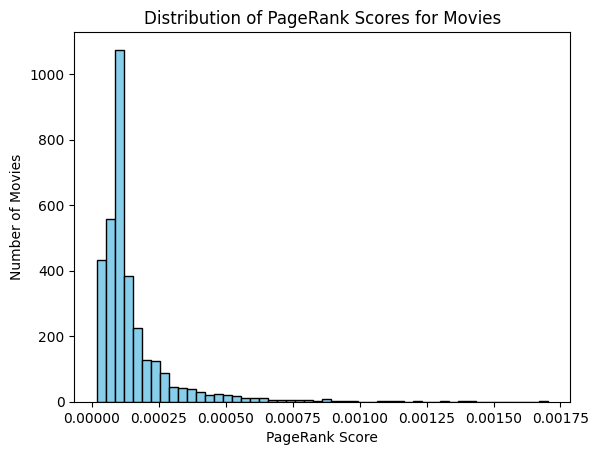

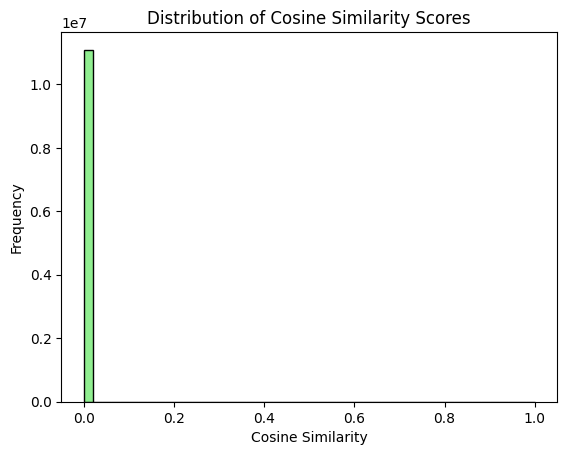

In [36]:
# Plot the distribution of PageRank scores for movies
pagerank_values = list(movie_pagerank_scores.values())
plt.hist(pagerank_values, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of PageRank Scores for Movies')
plt.xlabel('PageRank Score')
plt.ylabel('Number of Movies')
plt.show()

# Plot the distribution of cosine similarity scores between movies
cosine_values = cosine_sim_df.values.flatten()
plt.hist(cosine_values, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribution of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

 **Evaluating the Recommendation System**

In [37]:
pivot_table.head(10)

title,'Til There Was You (1997),"'burbs, The (1989)",(500) Days of Summer (2009),1-900 (06) (1994),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),102 Dalmatians (2000),11:14 (2003),12 (2007),...,Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zoom (2006),"Zorro, the Gay Blade (1981)",eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Leave out recommendation

In [39]:
def leave_out_movies(pivot_table, user_id, leave_out_count):
    """
    Leave out the top-rated movies for the user based on their ratings.

    Args:
    - pivot_table: The user-item matrix containing ratings.
    - user_id: The user whose movies are being left out.
    - leave_out_count: The number of top-rated movies to leave out.

    Returns:
    - train_pivot_table: The modified pivot table with the top-rated movies excluded.
    - left_out_movies: The list of movies that were left out (highest-rated).
    """
    # Step 1: Get the user's ratings
    user_ratings = pivot_table.loc[user_id]

    # Step 2: Sort the movies by ratings (highest first)
    top_rated_movies = user_ratings.sort_values(ascending=False).head(leave_out_count)

    # Step 3: Leave out the top-rated movies by setting their ratings to NaN
    left_out_movies = top_rated_movies.index.tolist()  # Movies that are left out

    train_pivot_table = pivot_table.copy()
    train_pivot_table.loc[user_id, left_out_movies] = np.nan  # Remove the top-rated movies

    return train_pivot_table, left_out_movies

In [40]:
def evaluate_leave_out(user_id, pivot_table, G, leave_out_count=1, top_n=10):
    """
    Evaluate the recommendation system for a given user by leaving out 'leave_out_count' movies,
    generating recommendations, and comparing with the ground truth (user ratings).

    Args:
    - user_id: The user for whom we are generating recommendations.
    - pivot_table: The user-item matrix containing ratings.
    - G: The bipartite graph for collaborative filtering.
    - leave_out_count: Number of movies to leave out for the user.
    - top_n: Number of recommendations to generate.

    Returns:
    - evaluation_results: A dictionary of evaluation metrics.
    """

    # Step 1: Leave out 'leave_out_count' movies for the user
    train_pivot_table, left_out_movies = leave_out_movies(pivot_table, user_id, leave_out_count)

    # Step 2: Generate recommendations for the user based on the remaining ratings
    recommended_movies = get_recommendations(user_id, G, train_pivot_table, top_n=top_n)
     # Step 3: Get the ground truth for the user (relevant items)
    relevant_items = pivot_table.loc[user_id].dropna()  # Ground truth (rated movies)
    relevant_ratings = relevant_items[relevant_items > 0]  # Keep only rated items

    # Step 4: Calculate Precision, Recall, F1-Score (as previously discussed)
    y_pred = [1] * leave_out_count
    y_true = [1 if movie in recommended_movies else 0 for movie in left_out_movies]

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Step 5: Return the evaluation metrics
    evaluation_results = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    return evaluation_results

In [41]:
def evaluate_leave_out_multiple(user_ids, pivot_table, G, leave_out_count=2,top_n=10):
    """
    Evaluate the recommendation system for multiple users and return the evaluation metrics as a DataFrame.

    Args:
    - user_ids (list): List of user IDs to evaluate.
    - pivot_table (pd.DataFrame): The pivot table containing user-item interactions (ratings).
    - model (surprise.AlgoBase): The collaborative filtering model to generate recommendations.
    - benchmark_model (function): Function to generate benchmark recommended movies (e.g., `get_recommendation_benchmark`).
    - G (networkx.Graph): The bipartite graph used for generating recommendations.
    - top_n (int): The number of top recommendations to consider (default 10).

    Returns:
    - pd.DataFrame: DataFrame containing the evaluation metrics for each user.
    """
    evaluation_results = []

    for user_id in user_ids:

        evaluation_metrics = evaluate_leave_out(user_id, pivot_table, G, leave_out_count=leave_out_count, top_n=top_n)
        # Add the evaluation metrics to the results
        evaluation_results.append({
            'User ID': user_id,
            'Precision': evaluation_metrics['Precision'],
            'Recall': evaluation_metrics['Recall'],
            'F1-Score': evaluation_metrics['F1-Score']
        })

    evaluation_df = pd.DataFrame(evaluation_results)
    return evaluation_df

In [42]:
multiple_evaluations = []

In [43]:
user_ids = pivot_table.index[:100]
evaluation_df = evaluate_leave_out_multiple(user_ids, pivot_table, G, leave_out_count=2,top_n=2)
multiple_evaluations.append({
            'Leave Out Count': 2,
            'Top N': 2,
            'Precision': evaluation_df['Precision'].mean(),
            'Recall': evaluation_df['Recall'].mean(),
            'F1-Score': evaluation_df['F1-Score'].mean()
        })
evaluation_df['Precision'].mean(), evaluation_df['Recall'].mean(), evaluation_df['F1-Score'].mean()

(0.0, 0.0, 0.0)

In [44]:
evaluation_df = evaluate_leave_out_multiple(user_ids, pivot_table, G, leave_out_count=2,top_n=100)
multiple_evaluations.append({
            'Leave Out Count': 2,
            'Top N': 100,
            'Precision': evaluation_df['Precision'].mean(),
            'Recall': evaluation_df['Recall'].mean(),
            'F1-Score': evaluation_df['F1-Score'].mean()
        })
evaluation_df['Precision'].mean(), evaluation_df['Recall'].mean(), evaluation_df['F1-Score'].mean()

(0.03, 0.06, 0.04)

In [45]:
evaluation_df = evaluate_leave_out_multiple(user_ids, pivot_table, G, leave_out_count=3,top_n=500)
multiple_evaluations.append({
            'Leave Out Count': 3,
            'Top N': 500,
            'Precision': evaluation_df['Precision'].mean(),
            'Recall': evaluation_df['Recall'].mean(),
            'F1-Score': evaluation_df['F1-Score'].mean()
        })
evaluation_df['Precision'].mean(), evaluation_df['Recall'].mean(), evaluation_df['F1-Score'].mean()

(0.12666666666666668, 0.36, 0.18600000000000003)

In [46]:
evaluation_df = evaluate_leave_out_multiple(user_ids, pivot_table, G, leave_out_count=2,top_n=1500)
multiple_evaluations.append({
            'Leave Out Count': 2,
            'Top N': 1500,
            'Precision': evaluation_df['Precision'].mean(),
            'Recall': evaluation_df['Recall'].mean(),
            'F1-Score': evaluation_df['F1-Score'].mean()
        })
evaluation_df['Precision'].mean(), evaluation_df['Recall'].mean(), evaluation_df['F1-Score'].mean()

(0.41, 0.71, 0.5099999999999999)

In [47]:
evaluation_results_df = pd.DataFrame(multiple_evaluations)
evaluation_results_df

,Leave Out Count,Top N,Precision,Recall,F1-Score
0,2,2,0.000000,0.00,0.000
1,2,100,0.030000,0.06,0.040
2,3,500,0.126667,0.36,0.186
3,2,1500,0.410000,0.71,0.510


In [48]:
print(evaluation_df)

    User ID  Precision  Recall  F1-Score
0        11        0.5     1.0  0.666667
1        14        0.0     0.0  0.000000
2        18        0.5     1.0  0.666667
3        44        0.5     1.0  0.666667
4        48        1.0     1.0  1.000000
..      ...        ...     ...       ...
95      578        0.5     1.0  0.666667
96      584        0.5     1.0  0.666667
97      586        0.0     0.0  0.000000
98      587        0.5     1.0  0.666667
99      594        0.5     1.0  0.666667

[100 rows x 4 columns]


**Evaluation of Recommendation System**

Visualizing the Evaluation metrics

In [49]:
def plot_line_metrics(df):
    plt.figure(figsize=(12, 6))

    # Plot Precision, Recall, F1-Score
    plt.plot(df['User ID'], df['Precision'], label='Precision', marker='o', color='blue')
    plt.plot(df['User ID'], df['Recall'], label='Recall', marker='o', color='green')
    plt.plot(df['User ID'], df['F1-Score'], label='F1-Score', marker='o', color='orange')

    # Add labels and title
    plt.title('Precision, Recall, and F1-Score per User ID for leave_out_count 2 and top_n as 1500')
    plt.xlabel('User ID')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

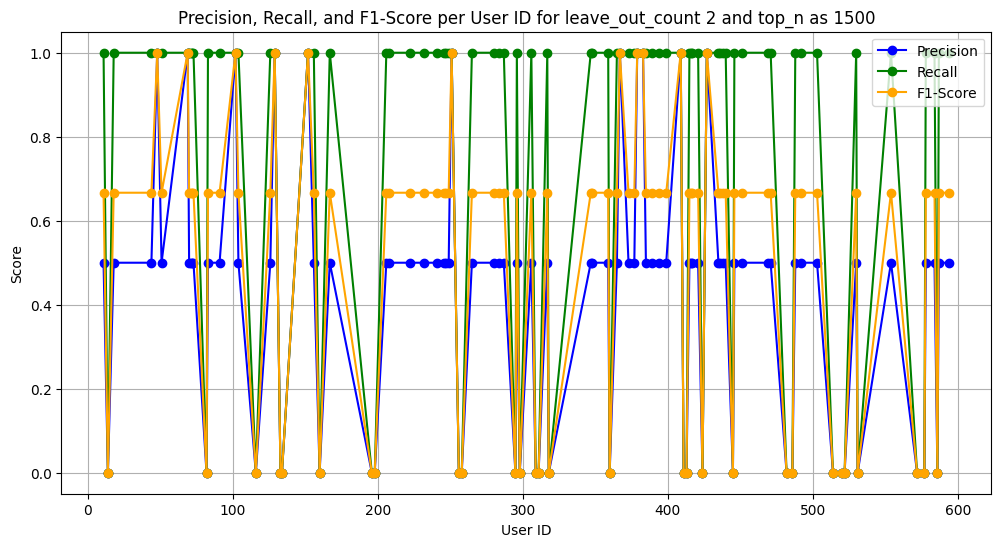

In [50]:
plot_line_metrics(evaluation_df)

In [51]:
def plot_individual_histograms(df):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot histogram for Precision
    axes[0].hist(df['Precision'], alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_title('Histogram of Precision')
    axes[0].set_xlabel('Precision')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)

    # Plot histogram for Recall
    axes[1].hist(df['Recall'], bins=10, alpha=0.7, color='green', edgecolor='black')
    axes[1].set_title('Histogram of Recall')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True)

    # Plot histogram for F1-Score
    axes[2].hist(df['F1-Score'], bins=10, alpha=0.7, color='orange', edgecolor='black')
    axes[2].set_title('Histogram of F1-Score')
    axes[2].set_xlabel('F1-Score')
    axes[2].set_ylabel('Frequency')
    axes[2].grid(True)
    # Adjust layout to make it look nice
    plt.tight_layout()
    plt.show()

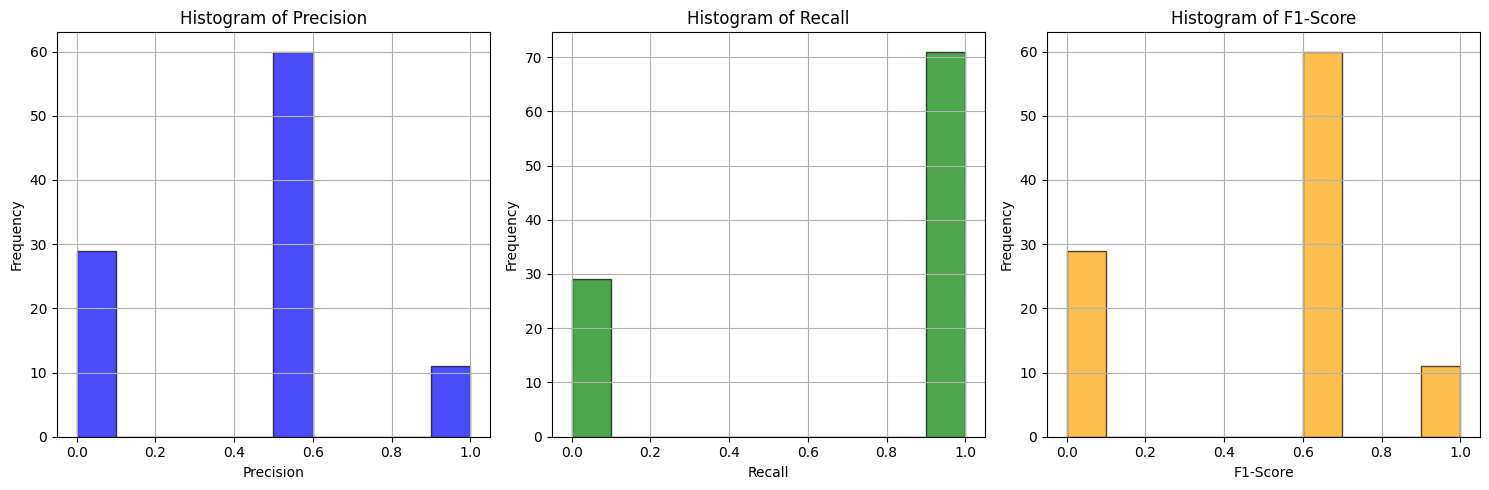

In [52]:
plot_individual_histograms(evaluation_df)